In [8]:
# import the required libraries
import pandas as pd
import ydata_profiling as pdpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv("balanced_preprocessed_data.csv")

### MODELING

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import time

model_performance = pd.DataFrame(columns=['Accuracy', 'Precision',
                                          'Recall', 'F1-Score', 'Training time',
                                          'Prediction time'])

def log_scores(model_name, y_test, y_predictions):
    accuracy = accuracy_score(y_test, y_predictions)
    precision = precision_score(y_test, y_predictions, average='weighted')
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1 = f1_score(y_test, y_predictions, average='weighted')

    # save the scores in model_performance dataframe
    model_performance.loc[model_name] = [accuracy, precision, recall, f1,
                                       end_train-start, end_predict-end_train]

### Data splitting and sampling

In [11]:
df.columns

Index(['operational_stress', 'temperature_differential', 'thermal_stress',
       'Tool wear', 'Process temperature', 'Rotational speed',
       'Machine failure'],
      dtype='object')

In [12]:
df.describe()

,operational_stress,temperature_differential,thermal_stress,Tool wear,Process temperature,Rotational speed,Machine failure
count,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000
mean,0.329128,-0.064525,-0.244026,1.360097,0.116787,0.104720,0.444467
std,1.155780,0.646460,0.926914,0.303599,0.917823,0.885399,0.496932
min,-1.532934,-1.294118,-2.732415,0.693147,-2.834821,-1.324468,0.000000
25%,-0.684063,-0.588235,-0.770321,1.118710,-0.542832,-0.601603,0.000000
50%,0.268097,-0.119242,-0.337795,1.433439,0.260991,-0.127430,0.000000
75%,1.226676,0.588235,0.343754,1.643540,0.737986,0.489362,1.000000
max,2.991315,1.352941,2.643927,1.787529,2.490683,2.389362,1.000000


70-30 dataset split (train, test)

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(["Machine failure"], axis=1)
y = df["Machine failure"]

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify = y)

### Decision Tree Model

In [14]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
model = DecisionTreeClassifier(max_depth = 8).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Decision Tree", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [15]:
print("Decision Tree\n" + classification_report(y_test, y_predictions))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1104
         1.0       0.90      0.94      0.92       883

    accuracy                           0.92      1987
   macro avg       0.92      0.93      0.92      1987
weighted avg       0.92      0.92      0.92      1987



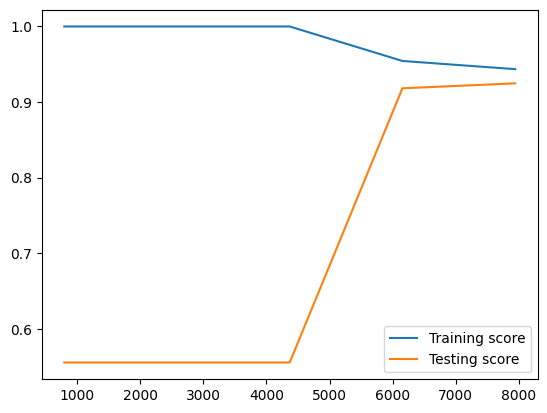

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of decision tree model

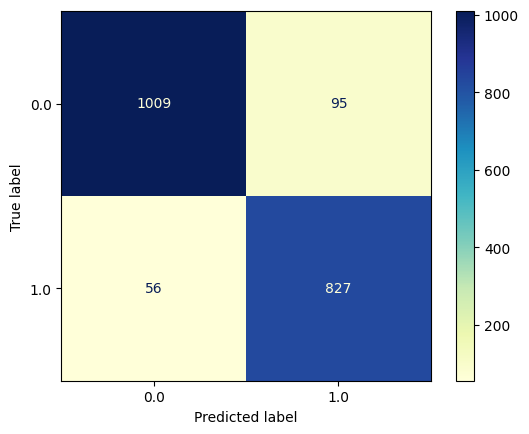

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Graph

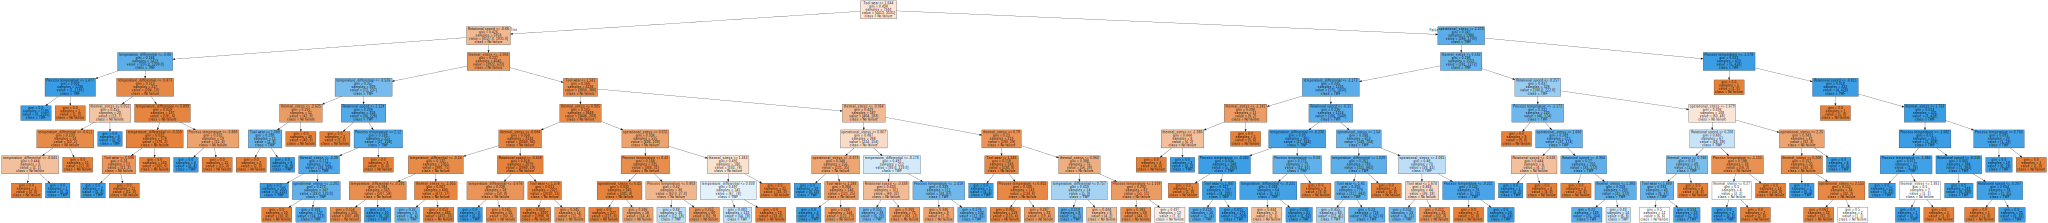

In [18]:
import graphviz
from sklearn import tree

data = tree.export_graphviz(model,
                            feature_names=X.columns,  
                            class_names=['No failure','TWF','HDF','PWF','OSF','RNF'],
                            filled=True)

# draw graph
graph = graphviz.Source(data, format="png") 
graph.render('nodes', view=False)
graph

In [19]:
from sklearn.tree import export_text

rules = export_text(model)

# print the rules
print(rules)

|--- feature_3 <= 1.64
|   |--- feature_5 <= -0.66
|   |   |--- feature_1 <= -0.66
|   |   |   |--- feature_4 <= 1.48
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_4 >  1.48
|   |   |   |   |--- class: 0.0
|   |   |--- feature_1 >  -0.66
|   |   |   |--- feature_1 <= -0.47
|   |   |   |   |--- feature_2 <= 0.05
|   |   |   |   |   |--- feature_1 <= -0.61
|   |   |   |   |   |   |--- feature_1 <= -0.64
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- feature_1 >  -0.64
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- feature_1 >  -0.61
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_2 >  0.05
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- feature_1 >  -0.47
|   |   |   |   |--- feature_1 <= 0.90
|   |   |   |   |   |--- feature_1 <= -0.36
|   |   |   |   |   |   |--- feature_3 <= 1.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- feature_3 >  1.00
|   |   |   |   |   |   |   |---

### k-NN (K-nearest neighbours) model

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# create the model
knn = KNeighborsClassifier()

# define the parameter grid
param_grid = {'n_neighbors': range(2, 20)}

# create the grid search object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best parameters
print(grid_search.best_params_)

{'n_neighbors': 2}


In [21]:
start = time.time()
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # predictions from the testset
end_predict = time.time()

# evaluate the model
log_scores("k-NN", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [22]:
print("k-NN Model\n" + classification_report(y_test, y_predictions))

k-NN Model
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1104
         1.0       0.94      0.96      0.95       883

    accuracy                           0.96      1987
   macro avg       0.96      0.96      0.96      1987
weighted avg       0.96      0.96      0.96      1987



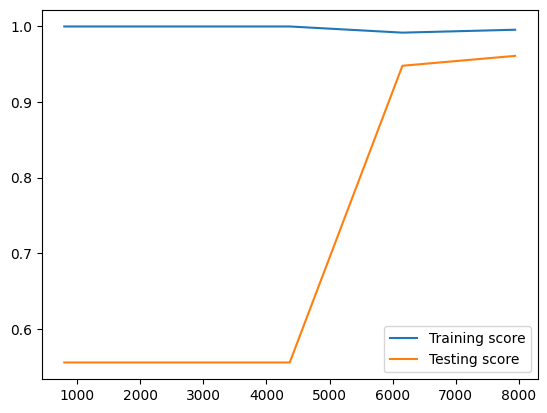

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix

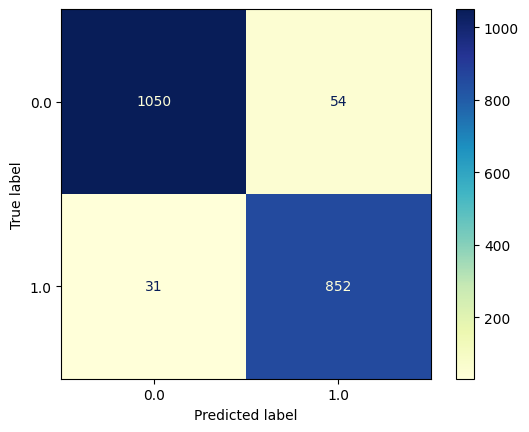

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Random forest Model

In [25]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                               random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Random Forest", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [26]:
print("Random Forest Model\n" + classification_report(y_test, y_predictions))

Random Forest Model
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1104
         1.0       0.97      0.97      0.97       883

    accuracy                           0.97      1987
   macro avg       0.97      0.97      0.97      1987
weighted avg       0.97      0.97      0.97      1987



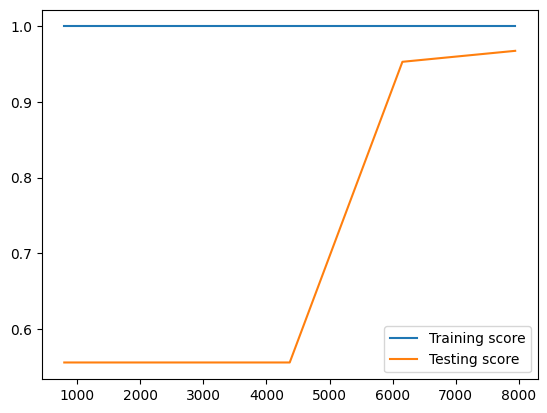

In [27]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Random Forest model

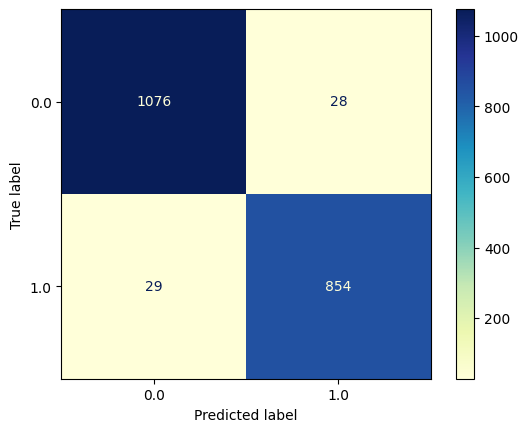

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Gradient Boosting Model

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gradient Boosting", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [30]:
print("Gradient Boosting\n" + classification_report(y_test, y_predictions))

Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      1104
         1.0       0.93      0.91      0.92       883

    accuracy                           0.93      1987
   macro avg       0.93      0.93      0.93      1987
weighted avg       0.93      0.93      0.93      1987



/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.p

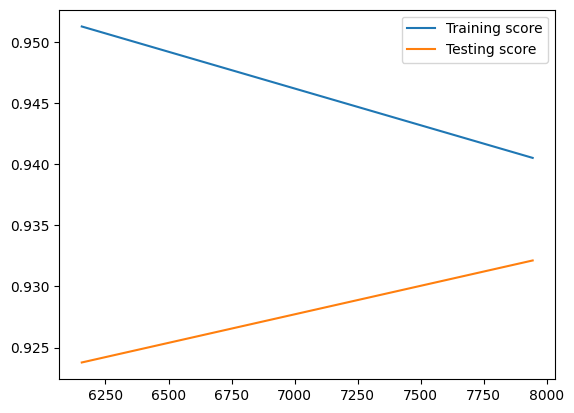

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Gradient Boosting model

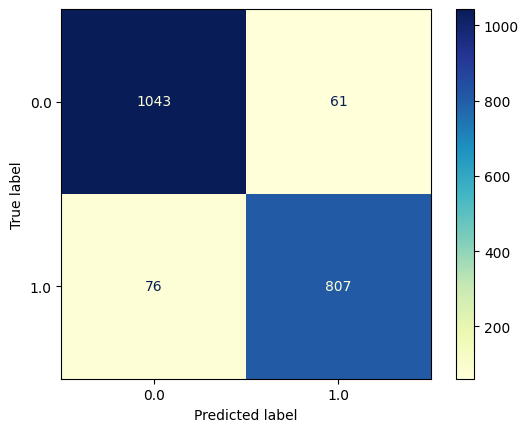

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Gaussian Naive Bayes Model

In [33]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
model = GaussianNB().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gaussian Naive Bayes", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [34]:
print("Gaussian Naive Bayes\n" + classification_report(y_test, y_predictions))

Gaussian Naive Bayes
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      1104
         1.0       0.73      0.71      0.72       883

    accuracy                           0.76      1987
   macro avg       0.76      0.75      0.75      1987
weighted avg       0.76      0.76      0.76      1987



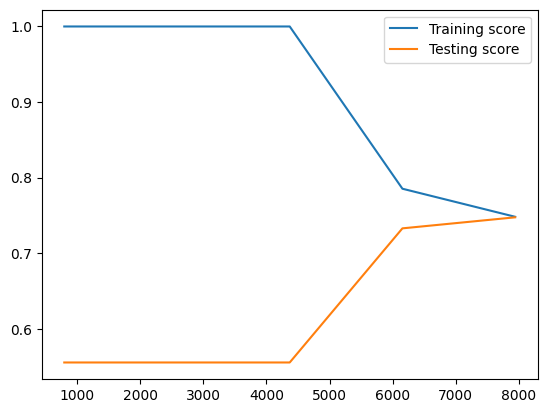

In [35]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Gaussian Naive Bayes model

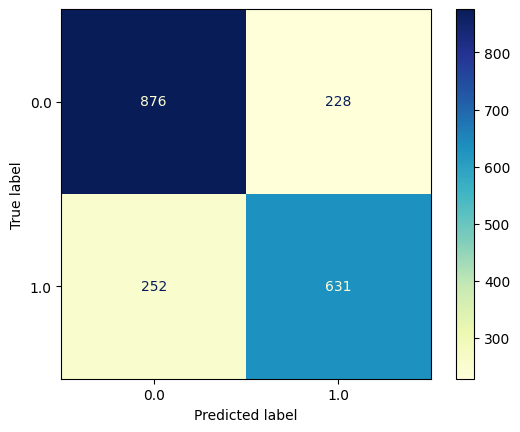

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### MLP (Multi-layer Perceptron) Model

In [37]:
from sklearn.neural_network import MLPClassifier

start = time.time()
model = MLPClassifier(random_state=1, max_iter=600, learning_rate="invscaling").fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Multi-layer Perceptron", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [38]:
print("Multi-layer Perceptron\n" + classification_report(y_test, y_predictions))

Multi-layer Perceptron
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      1104
         1.0       0.92      0.95      0.93       883

    accuracy                           0.94      1987
   macro avg       0.94      0.94      0.94      1987
weighted avg       0.94      0.94      0.94      1987



/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


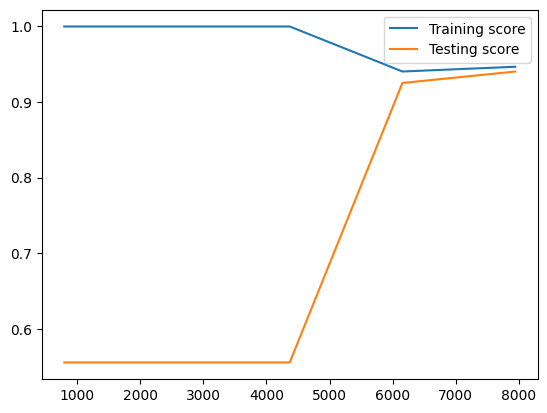

In [39]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

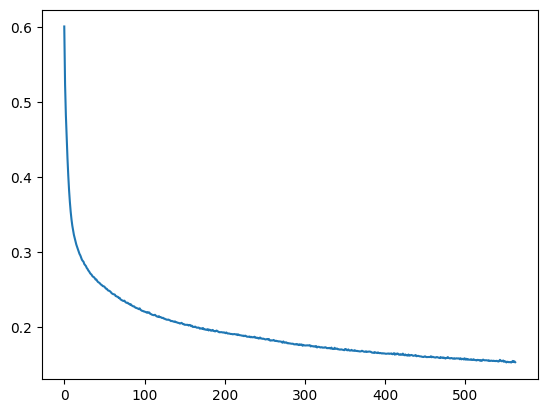

In [40]:
plt.plot(model.loss_curve_)

Confusion matrix of Multi-layer Perceptron model

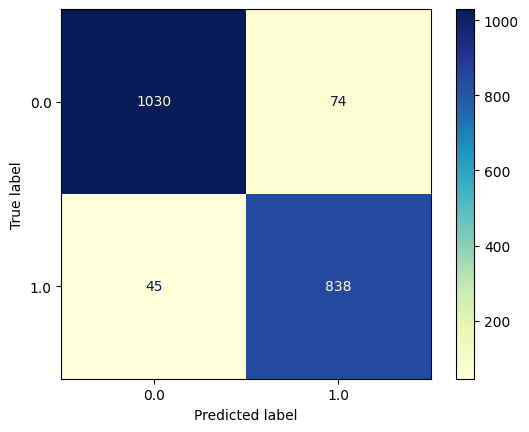

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Evaluation

In [42]:
model_performance

,Accuracy,Precision,Recall,F1-Score,Training time,Prediction time
Decision Tree,0.924006,0.924996,0.924006,0.924144,0.054693,0.002059
k-NN,0.957222,0.957580,0.957222,0.957272,0.022469,0.277009
Random Forest,0.971314,0.971311,0.971314,0.971312,0.462730,0.072119
Gradient Boosting,0.931052,0.931034,0.931052,0.930989,3.202734,0.014640
Gaussian Naive Bayes,0.758430,0.757922,0.758430,0.758064,0.003685,0.001838
Multi-layer Perceptron,0.940111,0.940684,0.940111,0.940196,20.683320,0.004006


In [43]:
df.describe()

,operational_stress,temperature_differential,thermal_stress,Tool wear,Process temperature,Rotational speed,Machine failure
count,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000,9931.000000
mean,0.329128,-0.064525,-0.244026,1.360097,0.116787,0.104720,0.444467
std,1.155780,0.646460,0.926914,0.303599,0.917823,0.885399,0.496932
min,-1.532934,-1.294118,-2.732415,0.693147,-2.834821,-1.324468,0.000000
25%,-0.684063,-0.588235,-0.770321,1.118710,-0.542832,-0.601603,0.000000
50%,0.268097,-0.119242,-0.337795,1.433439,0.260991,-0.127430,0.000000
75%,1.226676,0.588235,0.343754,1.643540,0.737986,0.489362,1.000000
max,2.991315,1.352941,2.643927,1.787529,2.490683,2.389362,1.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9931 entries, 0 to 9930
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   operational_stress        9931 non-null   float64
 1   temperature_differential  9931 non-null   float64
 2   thermal_stress            9931 non-null   float64
 3   Tool wear                 9931 non-null   float64
 4   Process temperature       9931 non-null   float64
 5   Rotational speed          9931 non-null   float64
 6   Machine failure           9931 non-null   float64
dtypes: float64(7)
memory usage: 543.2 KB
